# Radioastronomía

## Entregable 1 - Problema 1

En el enlace https://cloud.iac.es/index.php/s/rGd74CNmTAYkWLr se puede encontrar cinco mapas
(formato fits) obtenidos con el satélite WMAP alrededor de la radio galaxia del Cisne A (Cyg A),
correspondientes a cada una de las cinco bandas de frecuencia de este satélite: bandas K, Ka, Q, V y
W, con frecuencias centrales respectivamente de 22.8, 33.0, 40.6, 60.8 y 93.5 GHz. Se puede encontrar
información sobre éstos y otros parámetros caracterı́sticos de cada una de estas bandas de frecuencia en
este enlace: https://lambda.gsfc.nasa.gov/product/wmap/current/index.html. Estos mapas tienen
un tamaño de 5 grados (200 por 200 pı́xeles, siendo cada pı́xel un cuadrado de 1.5 arcmin de lado), están
centrados en coordenadas Galácticas l = 76.2 ◦ , b = +5.76◦, y tienen unidades de temperatura de brillo
RJ en mK. La resolución angular (FWHM) del patrón de recepción de WMAP en estas frecuencias es
respectivamente de 0.88, 0.66, 0.51, 0.35 y 0.22 grados.

 ### **Apartado a**  
 Calcule la densidad de flujo de Cyg A en cada una de estas frecuencias mediante la aplicación de una
fotometrı́a de apertura. Para ello, primero se debe sustraer, a todos los pı́xeles del mapa, un nivel de
fondo calculado a partir del valor promedio de todos los pı́xeles contenidos en un anillo comprendido
entre un radio θ 1 = 1,4 × θFWHM y un radio θ2 = 1,7 × θFWHM , y con coordenadas centrales las l, b de
Cyg A indicadas anteriormente. Posteriormente, para calcular la densidad de flujo, se debe integrar
todos los pı́xeles dentro de una apertura circular de radio θap = θFWHM centrada en las mismas
coordenadas l, b anteriores.

Empezamos con algunos imports:

In [28]:
# Imports:
from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from astropy.constants import c, h, k_B
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.signal import argrelextrema
import os, glob
import shutil
import matplotlib
from tabulate import tabulate

# Rendering con LaTEX:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Use a serif font for LaTeX rendering
plt.rc('font', size=16)  # Adjust size to your preference
# Define the LaTeX preamble with siunitx
plt.rcParams['text.latex.preamble'] = r'''
            \usepackage{siunitx}
            \sisetup{
              detect-family,
              separate-uncertainty=true,
              output-decimal-marker={.},
              exponent-product=\cdot,
              inter-unit-product=\cdot,
            }
            \DeclareSIUnit{\cts}{cts}
            \DeclareSIUnit{\dyn}{dyn}
            \DeclareSIUnit{\mag}{mag}
            \usepackage{sansmath}  % Allows sans-serif in math mode
            '''
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "mathptmx",
})

In [29]:
# Directorio con las figuras que se van a generar:
results_dir = "Figuras"
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir)

In [30]:
# Diccionario con los mapas:
data_maps = {
    "K": fits.getdata("wmap_K_cyga.fits")*u.mK,
    "Ka": fits.getdata("wmap_Ka_cyga.fits")*u.mK,
    "Q": fits.getdata("wmap_Q_cyga.fits")*u.mK,
    "V": fits.getdata("wmap_V_cyga.fits")*u.mK,
    "W": fits.getdata("wmap_W_cyga.fits")*u.mK,
}

# Diccionario con las frecuencias centrales:
data_freq = {
    "K": 22.8*u.GHz,
    "Ka": 33.0*u.GHz,
    "Q": 40.6*u.GHz,
    "V": 60.8*u.GHz,
    "W": 93.5*u.GHz,
}

# Diccionario con las resoluciones angulares:
data_FWHM = {
    "K": 0.88*u.deg,
    "Ka": 0.66*u.deg,
    "Q": 0.51*u.deg,
    "V": 0.35*u.deg,
    "W": 0.22*u.deg,
}

Visualizamos los 5 mapas

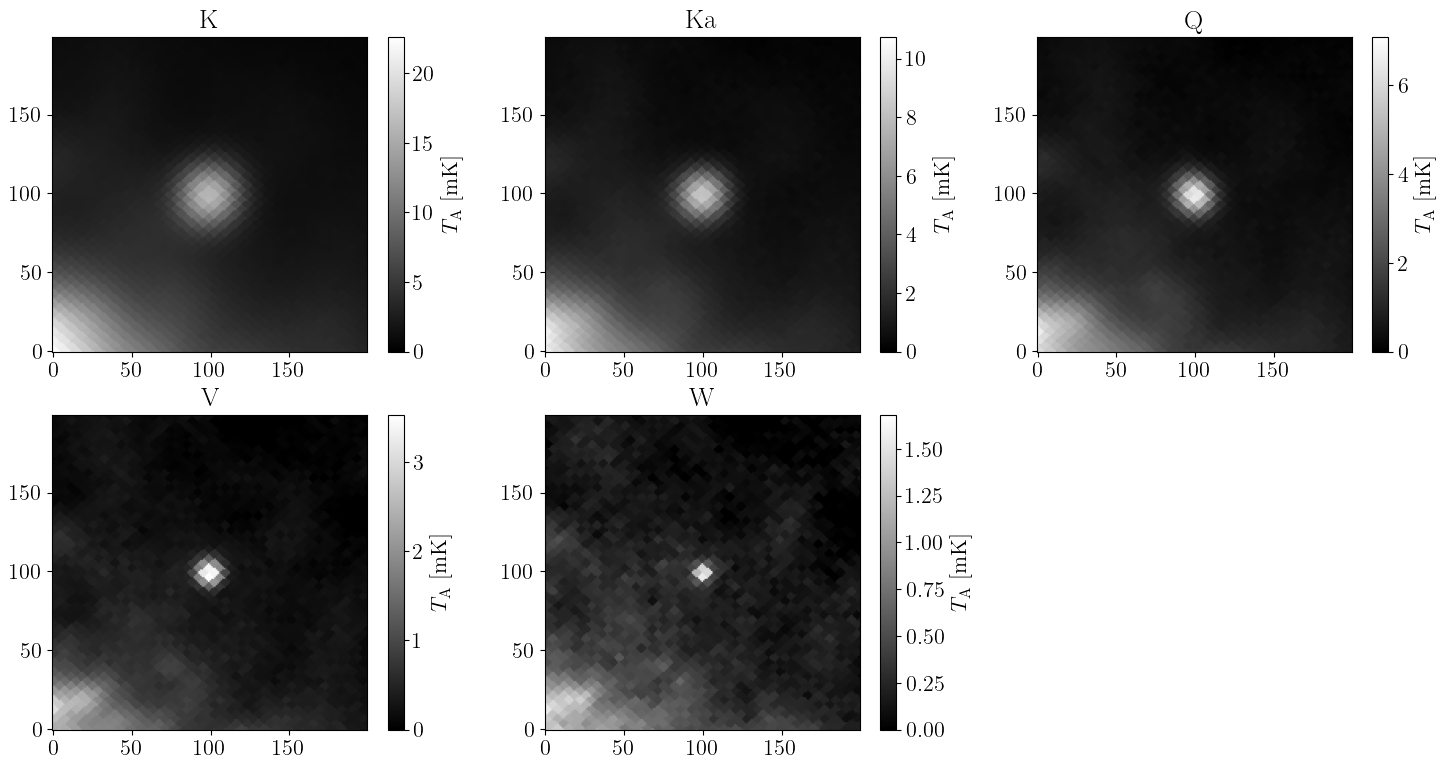

In [31]:
# Cremos una figura:
fig, ax = plt.subplots(2,3,figsize=(18,9))
ax = ax.flatten()

for i, (band, mapa) in enumerate(data_maps.items()):
    cax = ax[i].imshow(mapa.value, origin = 'lower', cmap = "gray", vmin=0)
    cbar = fig.colorbar(cax, ax=ax[i])
    cbar.set_label(r'$T_\mathrm{A}$ [$\unit{\milli\kelvin}$]', fontsize=16)
    cbar.ax.tick_params(axis='both', labelsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
    ax[i].set_title(band)
    #ax[i].scatter(100,100, color="red")
fig.delaxes(ax[-1])  # Borramos el sexto plot
fig.savefig(os.path.join(results_dir,"mapas.pdf"))



Calculamos un nivel de fondo promedio y se lo sustraemos a cada mapa

In [32]:
# Diccionario con los mapas que tendrán el fondo sustraído
data_maps_corr = {
    "K": np.empty_like(data_maps["K"]),
    "Ka": np.empty_like(data_maps["Ka"]),
    "Q": np.empty_like(data_maps["Q"]),
    "V": np.empty_like(data_maps["V"]),
    "W": np.empty_like(data_maps["W"]),
}


# Diccionario con los flujos integrados de Cyg A en cada banda:
data_flux = {
    "K": 0,
    "Ka": 0,
    "Q": 0,
    "V": 0,
    "W": 0,
}

Banda Flujo                         
--------------------------------------------------------------------------------
K     46.79020049645989              Jy
Ka    31.727119198091128             Jy
Q     24.279938498995513             Jy
V     14.533787615340788             Jy
W     6.6968118917451465             Jy


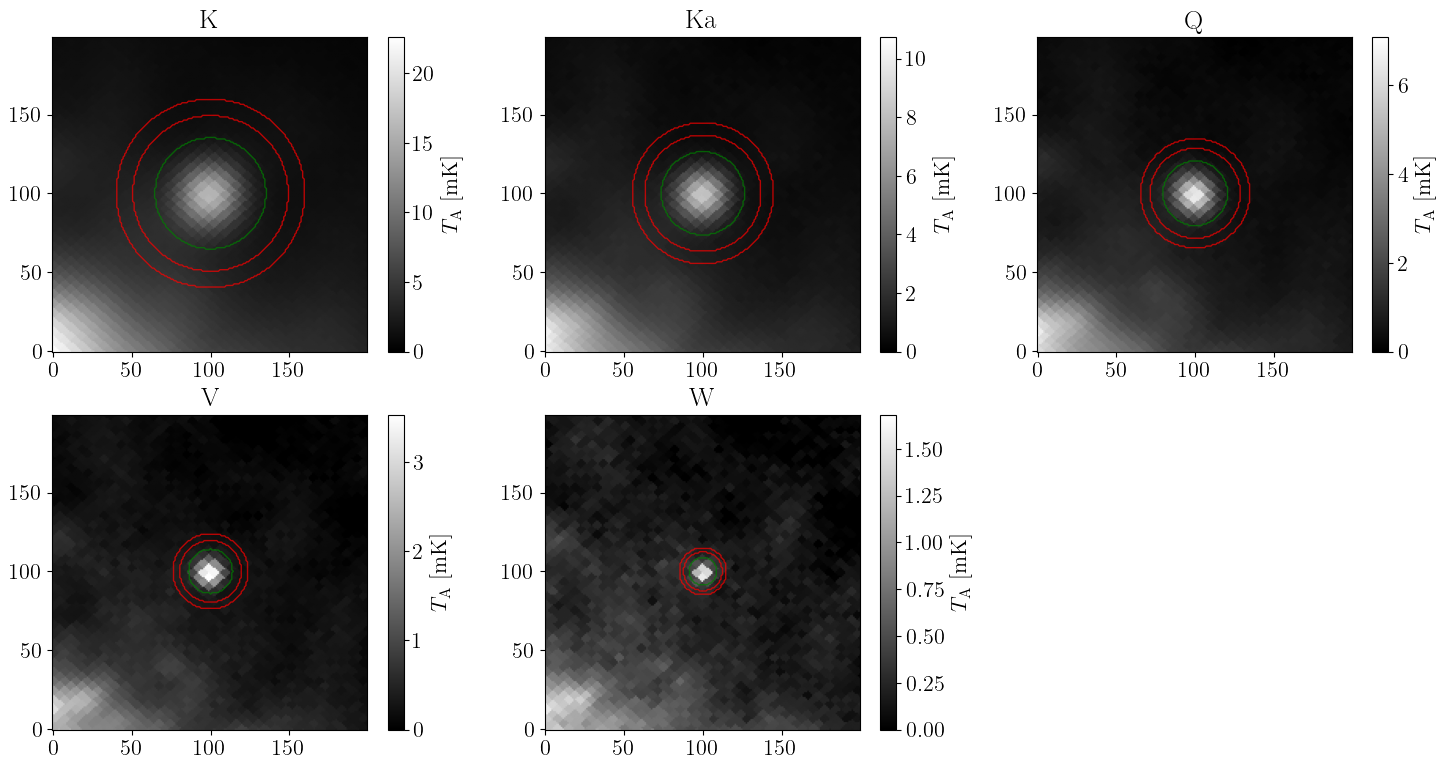

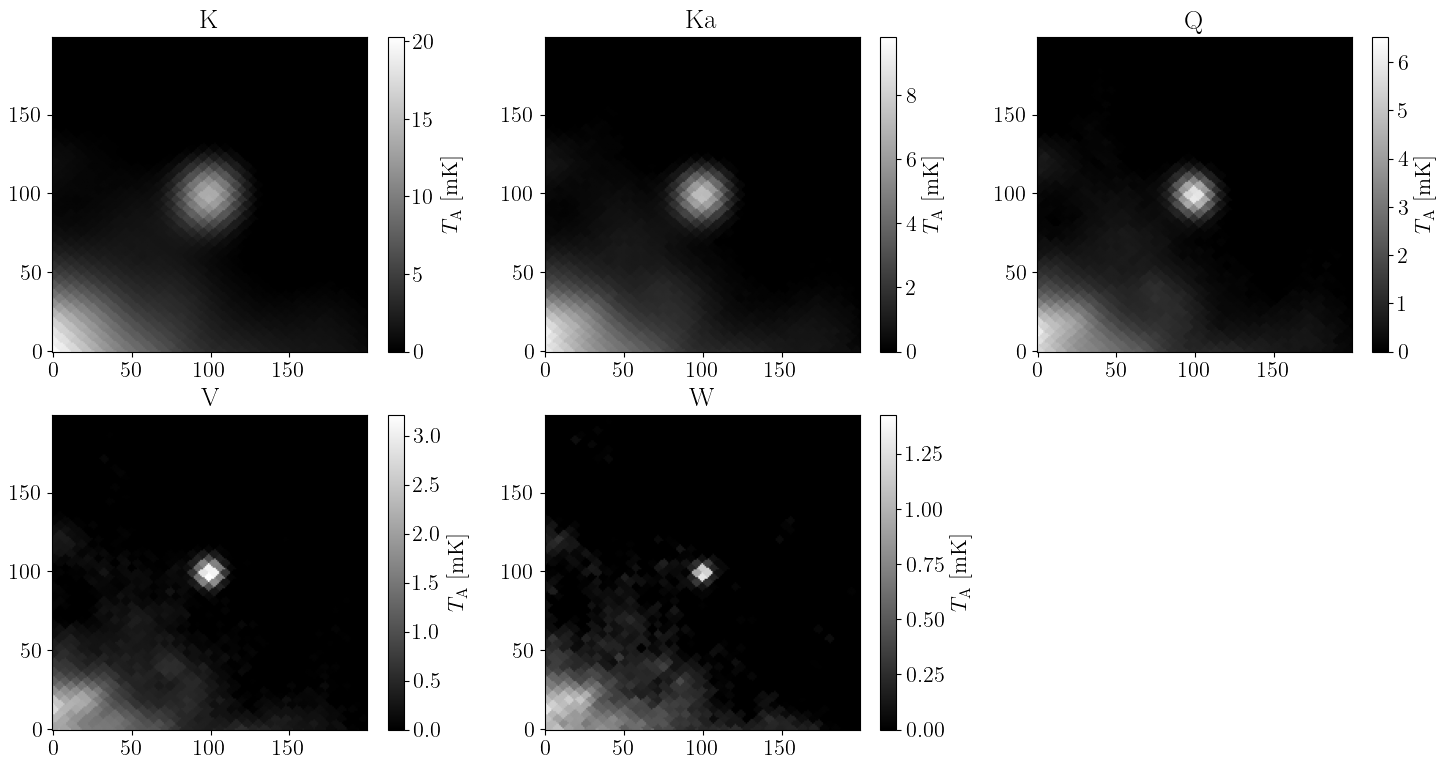

In [33]:
scale = 1.5*u.arcmin
# Cremos una figura donde dibujaremos los mapas originales junto con la máscara de selección:
fig, ax = plt.subplots(2,3,figsize=(18,9))
ax = ax.flatten()
# Cremos una figura donde dibujaremos los mapas con el fondo sustraído:
fig_corr, ax_corr = plt.subplots(2,3,figsize=(18,9))
ax_corr = ax_corr.flatten()

for i, (band, mapa) in enumerate(data_maps.items()):
    # Dibujo de los mapas originales
    cax = ax[i].imshow(mapa.value, origin = 'lower', cmap = "gray", vmin=0)
    cbar = fig.colorbar(cax, ax=ax[i])
    cbar.set_label(r'$T_\mathrm{A}$ [$\unit{\milli\kelvin}$]', fontsize=16)
    cbar.ax.tick_params(axis='both', labelsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
    ax[i].set_title(band)

    # Definimos los radios interior y exterior del anillo de integración para el fondo
    theta1 = 1.4*data_FWHM[band]
    theta2 = 1.7*data_FWHM[band]
    theta_ap = data_FWHM[band]
    
    # Obtenemos las dimensiones de la imagen (Cyg A está en el centro)
    ny, nx = mapa.shape
    center_x, center_y = nx // 2, ny // 2  # Centro de la imagen

    # Creamos la máscara del anillo para el fondo
    y, x = np.indices(mapa.shape)  # Crea una malla de coordenadas
    distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)*scale  # Distancia de cada píxel al centro (en píxeles). Matriz 200x200
    mask_ring = (distances >= theta1) & (distances <= theta2)
    ax[i].contour(mask_ring, colors='red', linewidths=1, alpha=0.7)

    # Creamos la máscara del circulo para la fotometría de apertura
    mask_circle = (distances <= theta_ap)
    ax[i].contour(mask_circle, colors='green', linewidths=1, alpha=0.7)

    # Calculamos el fondo promedio del anillo y lo sustraemos, guardando el nuevo mapa corregido:
    background = np.mean(mapa[mask_ring])
    data_maps_corr[band] = mapa - background

    # Calculamos el ángulo sólido subtendido por cada pixel:
    Omega = (scale**2).to(u.sr)
    # print(Omega)
    # Calculamos el flujo total de Cyg A en la banda:
    data_flux[band] = (2*k_B*data_freq[band]**2/c**2*np.sum(data_maps_corr[band][mask_circle])*Omega.value).to(u.W/u.m**2/u.Hz)

    # Dibujamos el mapa corregido en el plot correspondiente:
    cax_corr = ax_corr[i].imshow(data_maps_corr[band].value, origin = 'lower', cmap = "gray", vmin=0)
    cbar_corr = fig_corr.colorbar(cax_corr, ax=ax_corr[i])
    cbar_corr.set_label(r'$T_\mathrm{A}$ [$\unit{\milli\kelvin}$]', fontsize=16)
    cbar_corr.ax.tick_params(axis='both', labelsize=16)
    ax_corr[i].tick_params(axis='both', labelsize=16)
    ax_corr[i].set_title(band)

fig.delaxes(ax[-1])  # Borramos el sexto plot
fig.savefig(os.path.join(results_dir,"regiones.pdf"))
fig_corr.delaxes(ax_corr[-1])  # Borramos el sexto plot
fig_corr.savefig(os.path.join(results_dir,"mapas_sin_fondo.pdf"))

# Imprimir la tabla de forma bonita
print(f"{'Banda':<5} {"Flujo":<30}")
print("-" * 80)
for band, flux in data_flux.items():
    print(f"{band:<5} {flux.to(u.Jy):<30}")


 ### **Apartado b**  
Suponiendo que i) Cyg A (tamaño angular ∼35 arcsec) es una fuente puntual en esta observación, y ii)
los patrones de recepción de WMAP tienen forma Gaussiana y con las FWHMs dadas anteriormente,
¿qué fracción de la densidad de flujo de Cyg A queda fuera de la apertura?

La distribución de temperatura de antena es la convolución de la temperatura de brillo (en este caso una delta de Dirac porque la fuente es puntual) y el patrón de recepción (gaussiana). El resultado es una gaussiana. 

La fuente es puntual y por lo tanto todo el flujo de la fuente cae dentro de el mapa. Sin embargo, estamos integrando la señal solamente en un círculo cuya anchura es la FWHM

In [34]:
from scipy.special import erf

fracción_dentro = erf(2*np.sqrt(np.log(2)))
print(f"Fracción del flujo que queda dentro de la apertura: {fracción_dentro}")


Fracción del flujo que queda dentro de la apertura: 0.981468322248801


 ### **Apartado c**  
Utilizando las densidades de flujo obtenidas en las cuatro frecuencias anteriores, calcule el ı́ndice
espectral α de esta fuente (Sν ∝ ν α ).

Alpha vale -1.3705811245005126


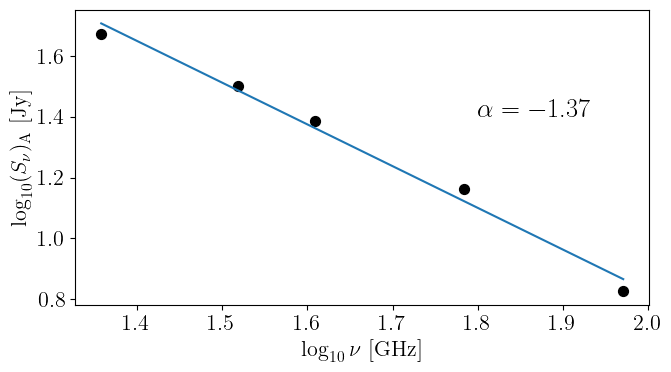

In [35]:
fig, ax = plt.subplots(figsize=(7,4))

freqs = np.array([f.value for f in list(data_freq.values())])
fluxes = np.array([t.to(u.Jy).value for t in list(data_flux.values())])

ax.scatter(np.log10(freqs), np.log10(fluxes), color="black", s=50)
ax.set_xlabel(r"$\log_{10}\nu$ [$\unit{\giga\hertz}$]")
ax.set_ylabel(r"$\log_{10}(S_\mathrm{\nu})_\mathrm{A}$ [$\mathrm{Jy}$]")

fit = np.polyfit(np.log10(freqs), np.log10(fluxes), 1)
xx = np.linspace(np.min(np.log10(freqs)), np.max(np.log10(freqs)),)
yy = np.polyval(fit, xx)
ax.plot(xx,yy)
ax.text(1.8,1.4, rf"$\alpha={fit[0]:.2f}$", fontsize=19, color="black")
fig.tight_layout()
fig.savefig(os.path.join(results_dir,"indice_espectral.pdf"))

print(rf"Alpha vale {fit[0]}")